In [51]:
import torch as t
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.nn import GRU

import warnings
warnings.simplefilter('ignore')

DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DATASET_PATH = './dataset/result.csv'


In [28]:
dataset = pd.read_csv(DATASET_PATH, index_col=0)
dataset.shape

(4382993, 79)

In [88]:
LOOK_FWD = 500
ds = dataset[:-LOOK_FWD]
ds['mid_price'] = ds[['p_ask_1', 'p_bid_1']].mean(axis=1)
mid_prices = dataset[['p_ask_1', 'p_bid_1']].mean(axis=1)
print('stage 1')
mid_prices_cum = np.zeros(ds.shape[0])
for i in tqdm(range(mid_prices_cum.shape[0])):
    mid_prices_cum[i] = mid_prices[i:i+LOOK_FWD].sum()

print('stage 2')
mid_prices_cum /= LOOK_FWD
mid_prices_cum = np.stack([mid_prices_cum, mid_prices[:-LOOK_FWD]], axis=1)

# ds['mid_5_fwd'] = dataset[['p_ask_1', 'p_bid_1']].mean(axis=1)[LOOK_FWD:].to_numpy()
# labels = ds['mid_price'] - ds['mid_5_fwd']
# thr = ds['mid_price'].mean() / 1e20
# # thr = 0
# labels = labels.apply(lambda x: 2 if np.abs(x) <= thr else int(x < 0))
# labels

stage 1


100%|██████████| 4382493/4382493 [02:56<00:00, 24799.48it/s]

stage 2


In [93]:
%%time
THR = 0.000001
def categorize(x):
    m = x[0] / x[1]
    if m > 1 + THR:
        return 1
    if m < 1 - THR:
        return 0
    return 2
labels = np.apply_along_axis(categorize, 1, mid_prices_cum)
labels

CPU times: user 3.67 s, sys: 0 ns, total: 3.67 s
Wall time: 3.67 s


array([2, 2, 2, ..., 2, 2, 2])

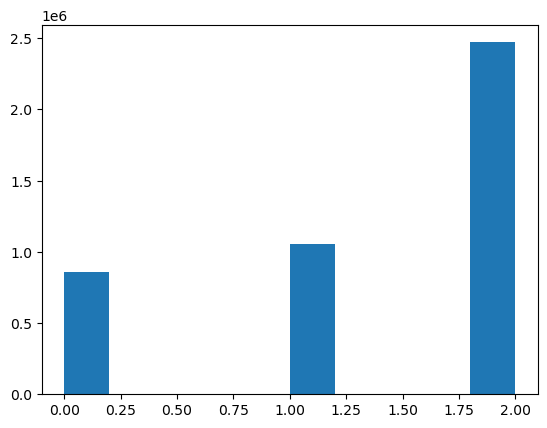

In [94]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [60]:
class Pipe:
    def __init__(self, window_size=20, window_step=1):
        self.mean = None
        self.w_size=window_size
        self.w_step=window_step
        self.columns = None

    def fit(self, x:pd.DataFrame):
        self.max = t.tensor(x.max(axis=0).to_numpy())
        self.columns = x.columns + ['mid_price']

    def transform(self, x:pd.DataFrame) -> t.tensor:
        x_t = t.tensor(x.to_numpy())
        x_t /= self.max
        x_t = t.concat([x_t,
                        x_t[:, [0,2]]
                       .mean(axis=1)
                       .unsqueeze(0).T]
                    , axis=1)
        x_t = x_t.unfold(0, self.w_size, self.w_step)

        return x_t

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)


In [61]:
pipe = Pipe()
pipe.fit_transform(dataset).shape

torch.Size([4382974, 80, 20])

In [4]:
test = t.tensor(np.random.randn(10,5))
print(test.shape)
test = test.unfold(0,3,1)
test.shape

torch.Size([10, 5])


torch.Size([8, 5, 3])

In [21]:
slide_size = 20

ds_tensor = t.tensor(dataset.to_numpy())
ds_tensor = ds_tensor.unfold(0, 20, 1)
ds_tensor = ds_tensor.permute(0,2,1)
ds_tensor.shape

torch.Size([4382974, 20, 79])

In [27]:
# params
items = 3
sequence_len = 10
features = 20
K = 6
n_layers = 2

# test tensor
test = t.randn((items, sequence_len, features))

# init of first hidden state
h_0 = t.randn((n_layers, sequence_len, K))
gru = GRU(
    input_size = features,
    hidden_size = K,
    num_layers = n_layers,
    bidirectional=False
)

gru(test, h_0)[0].shape

torch.Size([3, 10, 6])